In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import anndata
import sc_utils
import scvi

Global seed set to 0
/projects/b1038/Pulmonary/nmarkov/2022-multimodal/code/venv/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/projects/b1038/Pulmonary/nmarkov/2022-multimodal/code/venv/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [2]:
pd.options.display.max_rows = 200

In [3]:
%config InlineBackend.figure_format = "retina"

# Train scVI

Plan:
1. Train scVI on HVG with batches
2. See that its latent space recapitulates what we saw in exploratory
3. Use latent space to predict proteins

Improvement ideas:
1. Use scanVI with `diff_leiden` as labels
2. Select more HVGs
3. Change network setup / layer sizes

## 1. Load data

In [15]:
ds = sc.read_h5ad("../data/h5ad/rna.h5ad")

`ds.X` contains scaled values right now, let's get log-normalized gene expression back

In [16]:
ds = ds.raw.to_adata()

This object has `raw` with all genes, but we already selected 2000 HVGs, let's try using these first

In [19]:
ds = ds[:, ds.var.highly_variable].copy()

## 2. scVI model

In [20]:
scvi.model.SCVI.setup_anndata(ds, batch_key="sample")

/projects/b1038/Pulmonary/nmarkov/2022-multimodal/code/venv/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:90: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(


In [21]:
vae = scvi.model.SCVI(
    ds, 
    n_latent=50, 
    n_layers=2, 
    dropout_rate=0.2, 
    gene_likelihood="nb",
    use_observed_lib_size=False,
    encode_covariates=True,
    deeply_inject_covariates=False,
    log_variational=False
)

In [22]:
vae.train(
    max_epochs=400, 
    use_gpu=True, 
    check_val_every_n_epoch=2,
    early_stopping=True
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 369/400:  92%|███████████████████████████████████████████████████████▎    | 369/400 [1:21:16<06:49, 13.22s/it, loss=1.37e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 1365.006. Signaling Trainer to stop.


In [23]:
vae.save("03rna.model", override=False)

In [24]:
vae.summary_stats

attrdict({'n_vars': 2000, 'n_cells': 119651, 'n_batch': 16, 'n_labels': 1, 'n_extra_categorical_covs': 0, 'n_extra_continuous_covs': 0})

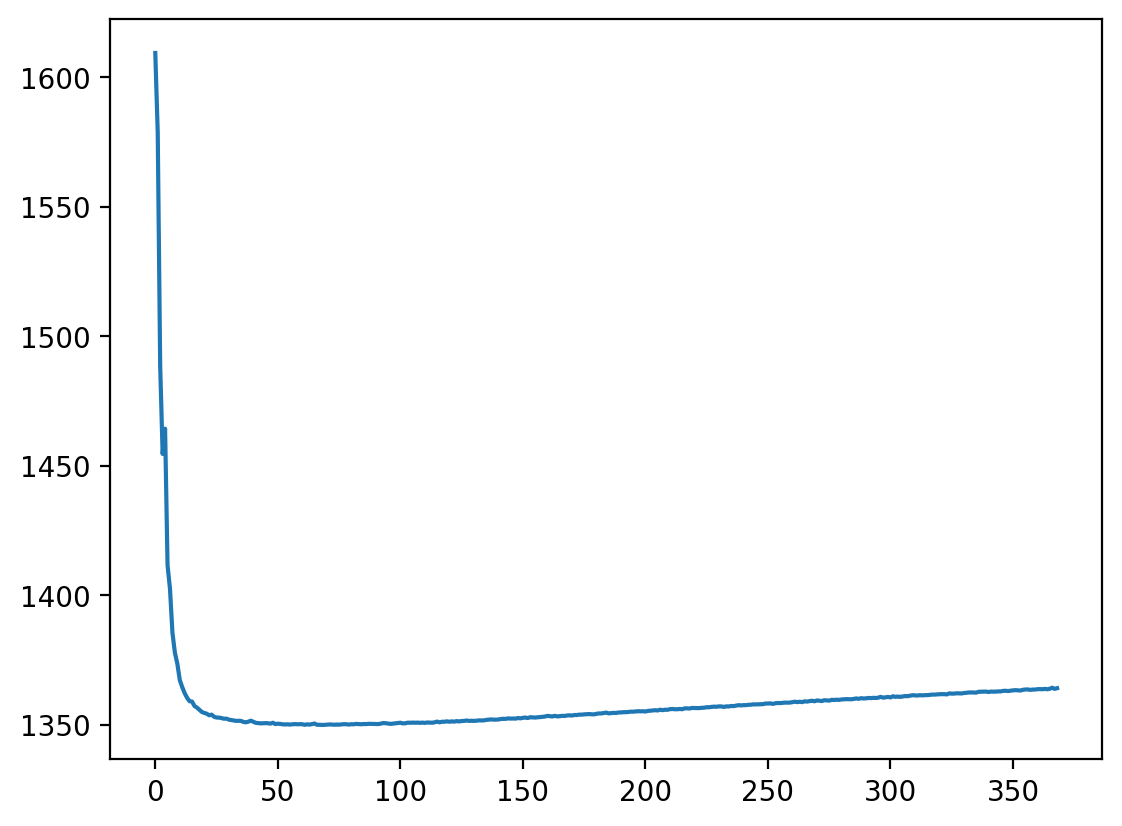

In [35]:
df = vae.history["validation_loss"]
plt.plot(df.index, df)

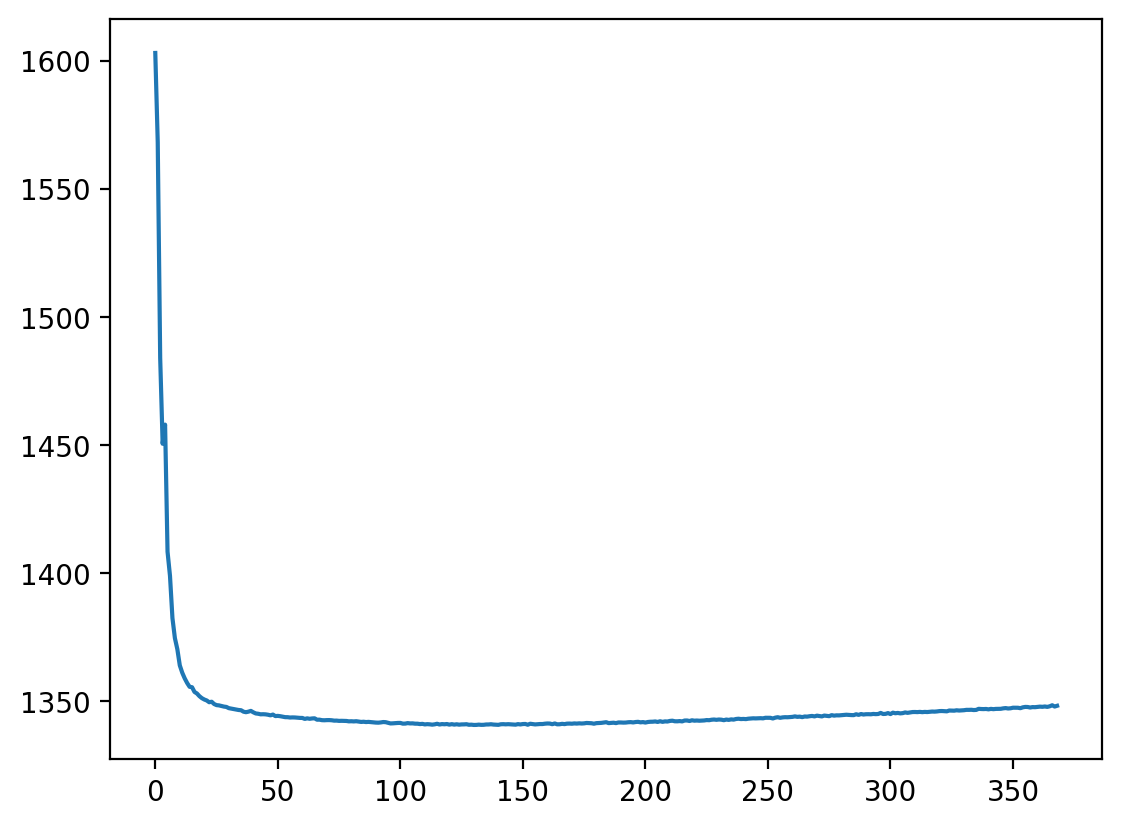

In [42]:
df = vae.history["reconstruction_loss_validation"]
plt.plot(df.index, df)

In [25]:
ds.obsm["X_scVI"] = vae.get_latent_representation(ds)

In [26]:
sc.pp.neighbors(ds, use_rep="X_scVI", key_added="scvi_neighbors")

In [27]:
sc.tl.leiden(ds, key_added="scvi_leiden", neighbors_key="scvi_neighbors")

/projects/b1038/Pulmonary/nmarkov/2022-multimodal/code/venv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/projects/b1038/Pulmonary/nmarkov/2022-multimodal/code/venv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


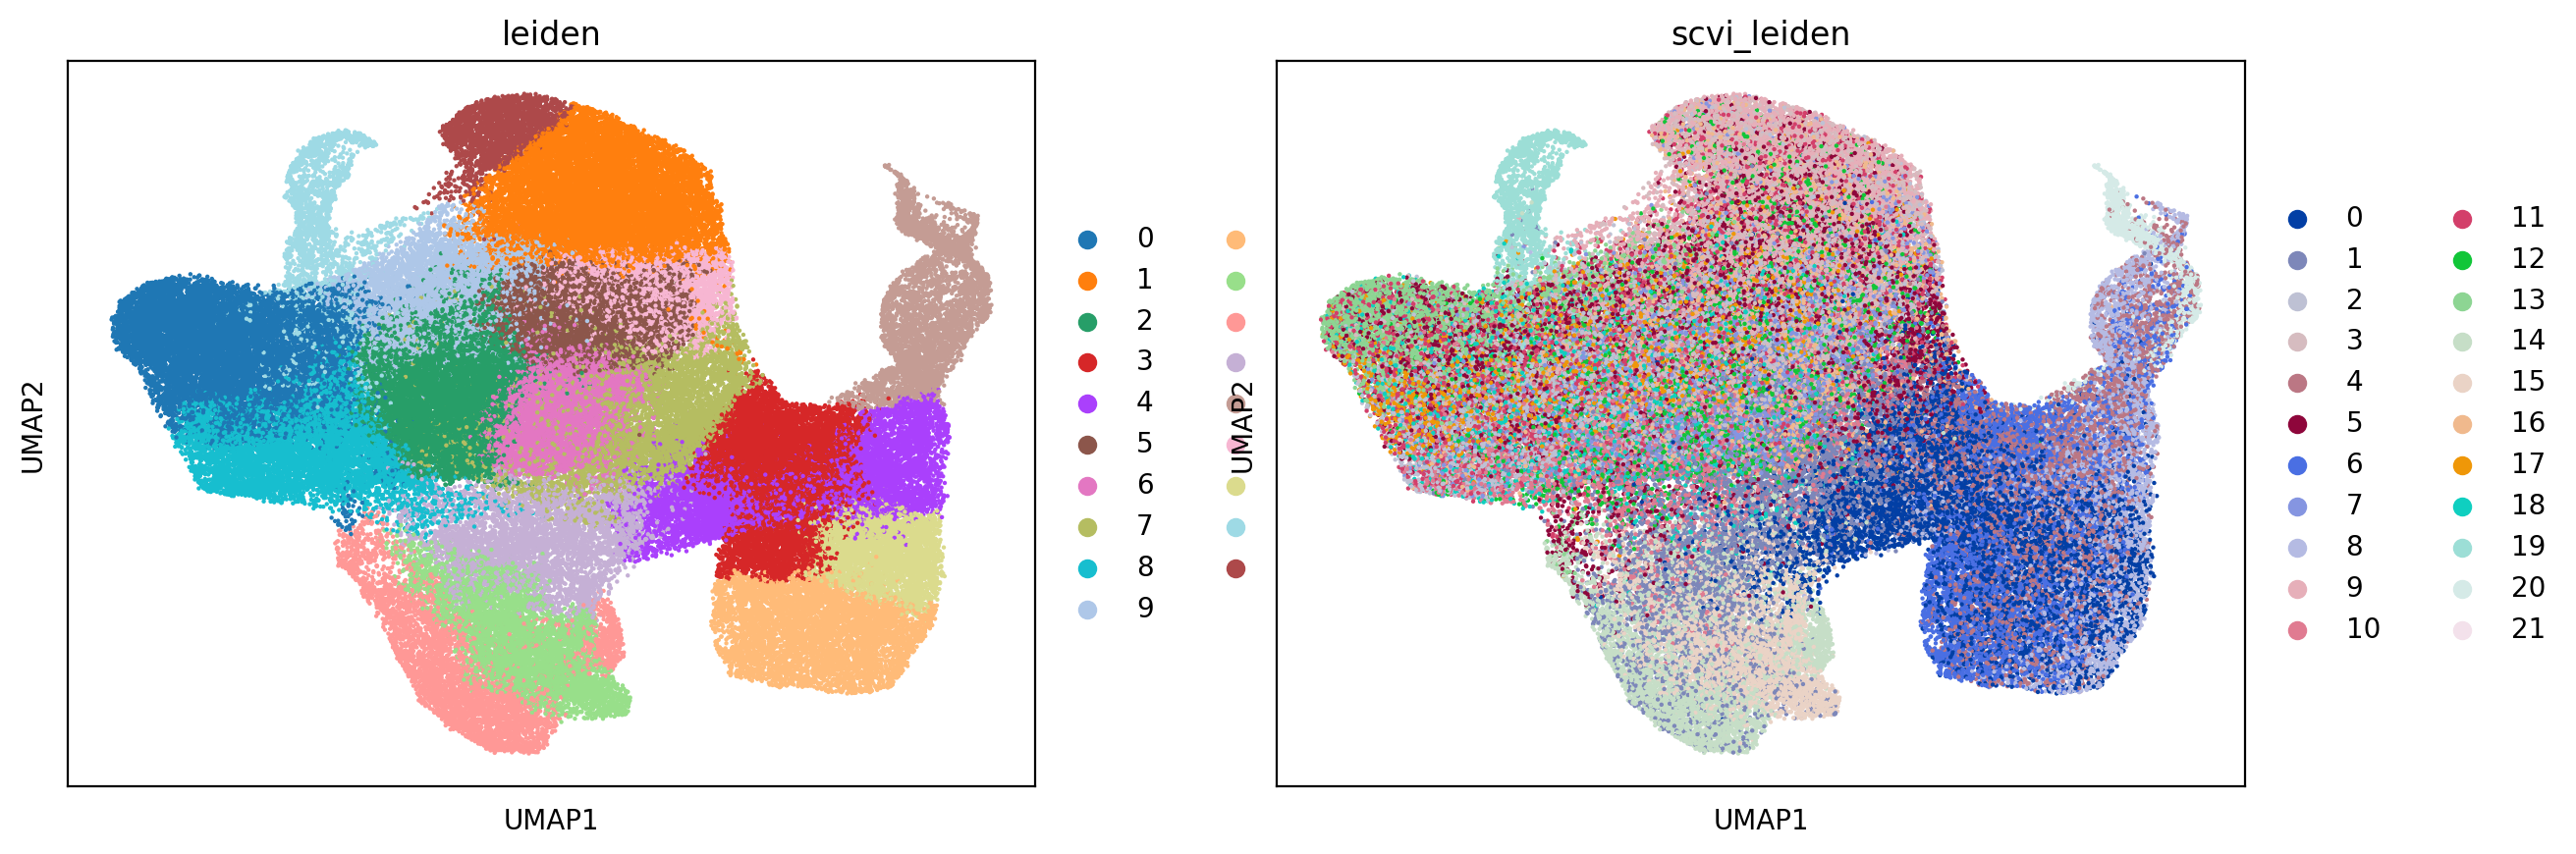

In [28]:
sc.pl.umap(ds, color=["leiden", "scvi_leiden"], size=10)

<AxesSubplot: title={'center': 'Leiden by scvi_leiden'}>

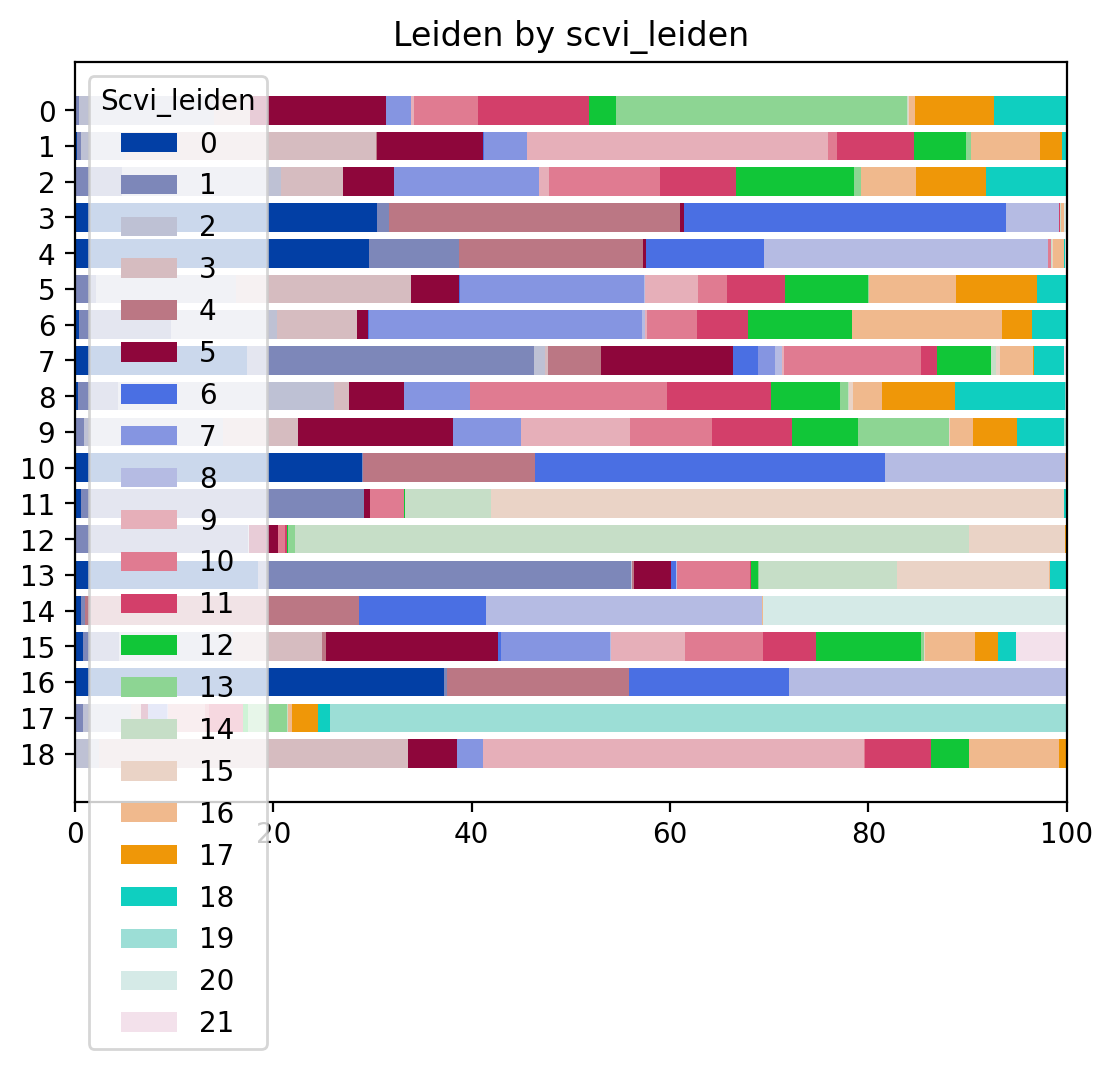

In [31]:
sc_utils.plot_composition(ds, group_by="leiden", color="scvi_leiden", relative=True)

<AxesSubplot: title={'center': 'Scvi_leiden by leiden'}>

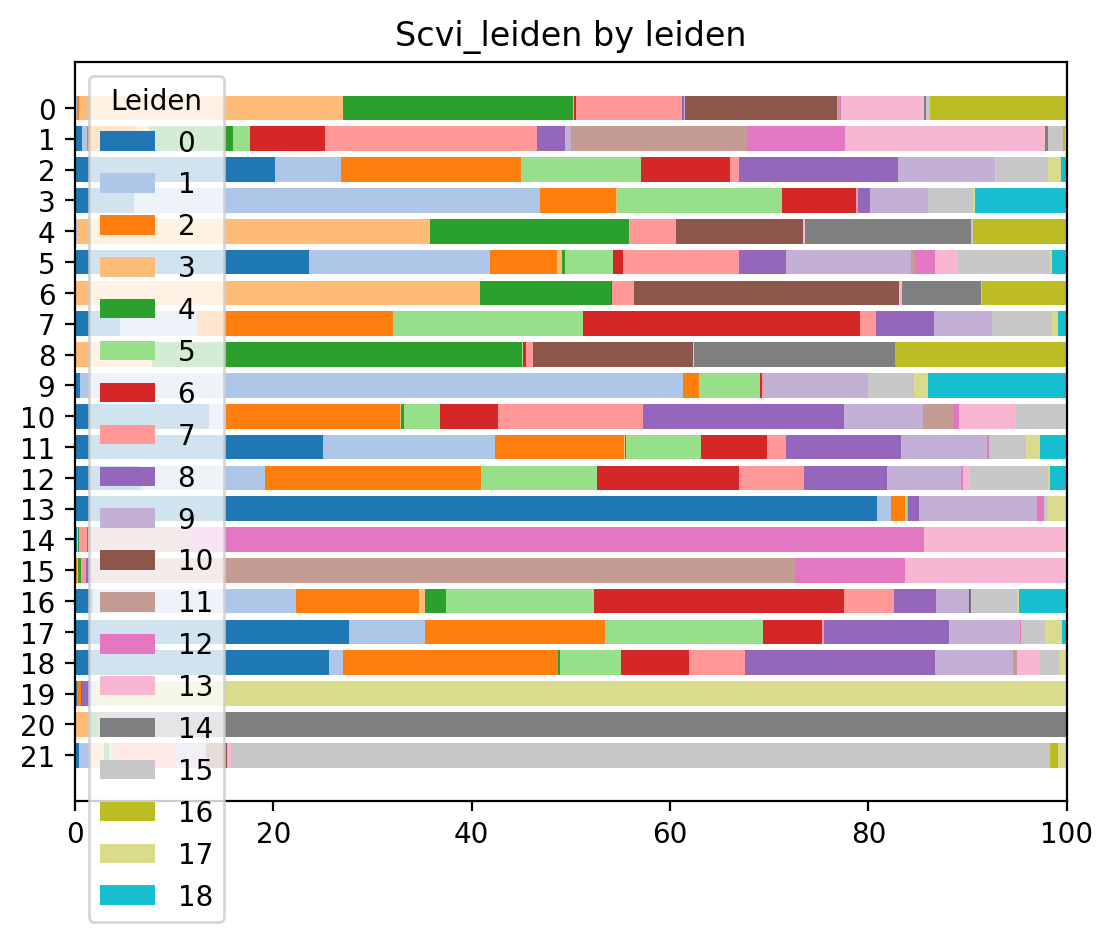

In [32]:
sc_utils.plot_composition(ds, group_by="scvi_leiden", color="leiden", relative=True)

**Conclusion**:
* not great agreement with previous analysis
* this is not exactly scVI model's framework (because of log-normalized counts)

In [43]:
ds.obsm["X_scVI"]

array([[-1.1297804e+00,  5.4771686e-01, -1.3588403e-02, ...,
        -2.5565294e-04, -1.4825838e+00, -6.2293720e-01],
       [-7.6397091e-01, -5.8064169e-01, -9.2887720e-03, ...,
        -7.1986206e-03, -6.3817304e-01, -2.0448519e-01],
       [-1.5418934e+00, -8.6065435e-01, -1.3324860e-03, ...,
         7.7264989e-03,  6.1047393e-01,  9.1364336e-01],
       ...,
       [ 2.2025275e+00,  2.8887337e-01,  1.1312828e-02, ...,
        -1.0701849e-02, -1.0778481e+00, -4.9808964e-01],
       [-8.9233500e-01,  3.0280286e-01, -7.6455586e-03, ...,
        -1.3642979e-03,  4.7044972e-01,  1.1128490e+00],
       [-1.3743578e+00,  5.7187587e-02,  1.3328111e-03, ...,
         9.6454602e-03,  6.0788435e-01,  7.1829483e-02]], dtype=float32)